In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


In [ ]:
#importing Required Libraries

import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K

In [ ]:
#Loading Dataset from Pre Loaded Numpy object of Training Dataset 

Traning_Images = np.load("Traning_Images.npy")
Traning_Labels = np.load("Traning_Labels.npy")

In [ ]:
#Preprocessing

from keras.utils import to_categorical
y_train=to_categorical(Traning_Labels)

Traning_Labels = []

print((Traning_Images.shape,y_train.shape))

#train_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.5)

#val_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.5)

#train_generator.fit(x_train)
#val_generator.fit(x_val)

((1803, 683, 1024, 3), (1803, 4))


In [ ]:
def identity_block(X, f, filters, stage, block):
    
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
   
    F1, F2, F3 = filters
    
    
    X_shortcut = X
    
    
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    
    X = layers.Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    
    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s = 2):
   
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    
    F1, F2, F3 = filters
    
    
    X_shortcut = X


    
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    

     
    X = Conv2D(F2, (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

     
    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    
    X = layers.Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [ ]:
def ResNet50(input_shape = (683, 1024, 3), classes = 4):
   
    
    
    X_input = Input(input_shape)

    
    
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    

    # Stage 3 
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL
    X = AveragePooling2D((2,2), name='avg_pool')(X)
    

    # output layer
    X = Flatten()(X)

    #Final Dense Layer With 4 output As our Category
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [ ]:
#Defining Model Object
model = ResNet50(input_shape = (683, 1024, 3), classes = 4)

In [ ]:
#Compilation Of Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#Training Of Model

model.fit(Traning_Images, y_train, epochs = 50, batch_size = 8)

Epoch 1/50
226/226 [==============================] - 479s 2s/step - loss: 10.3099 - accuracy: 0.3283
Epoch 2/50
226/226 [==============================] - 478s 2s/step - loss: 1.2189 - accuracy: 0.4487
Epoch 3/50
226/226 [==============================] - 478s 2s/step - loss: 1.1416 - accuracy: 0.4986
Epoch 4/50
226/226 [==============================] - 478s 2s/step - loss: 0.8969 - accuracy: 0.6578
Epoch 5/50
226/226 [==============================] - 478s 2s/step - loss: 0.8040 - accuracy: 0.7199
Epoch 6/50
226/226 [==============================] - 479s 2s/step - loss: 0.6536 - accuracy: 0.7532
Epoch 7/50
226/226 [==============================] - 478s 2s/step - loss: 0.6015 - accuracy: 0.7865
Epoch 8/50
226/226 [==============================] - 479s 2s/step - loss: 0.5715 - accuracy: 0.7815
Epoch 9/50
226/226 [==============================] - 479s 2s/step - loss: 0.5460 - accuracy: 0.8087
Epoch 10/50
226/226 [==============================] - 479s 2s/step - loss: 0.4802 - accur

In [ ]:
#Saving Model
import h5py
from keras.models import load_model
model= load_model("model.h5")

In [ ]:
import cv2 

DataDir2 = "Dataset/Tst//"
Testing_Images = []

img1 = cv2.imread('Train/scab_11.jpeg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
new_array = cv2.resize(img1, (1024,683))
Testing_Images.append(new_array)


Testing_Images = np.array(Testing_Images)
print(type(Testing_Images))
print((Testing_Images).shape)
print(Testing_Images)

<class 'numpy.ndarray'>
(1, 683, 1024, 3)
[[[[ 87 101  52]
   [ 87 101  52]
   [ 87 101  52]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[ 87 101  52]
   [ 87 101  52]
   [ 87 101  52]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[ 86 100  51]
   [ 86 100  51]
   [ 86 100  51]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  ...

  [[ 28  46  24]
   [ 28  46  24]
   [ 29  46  24]
   ...
   [ 87  81  57]
   [ 87  81  57]
   [ 87  81  57]]

  [[ 28  46  24]
   [ 28  46  24]
   [ 28  46  24]
   ...
   [ 87  81  57]
   [ 87  81  57]
   [ 87  81  57]]

  [[ 28  46  24]
   [ 28  46  24]
   [ 28  46  24]
   ...
   [ 87  81  57]
   [ 87  81  57]
   [ 87  81  57]]]]


In [ ]:
predictions = model.predict([Testing_Images])

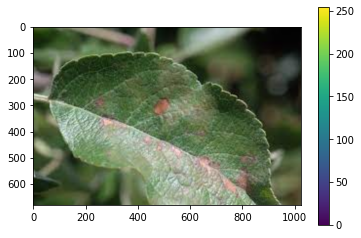

Scab


In [ ]:
import matplotlib.pyplot as plt
class_name = ['Healthy','Multiple_Disease','Rust','Scab']
for i in range(0,1):
  plt.figure()
  plt.imshow(Testing_Images[i],)
  plt.colorbar()
  plt.grid(False)
  #plt.xlabel(Class_Name[Testing_Labels[i]])
  plt.show()
  #print(np.argmax(predictions[i]))
  prd_cls = np.argmax(predictions[i])
  cls = class_name[prd_cls]
  print(cls)